# `dmnautilus` mark 2

Inverts the SNR threshold logic – that is
to make the SNR be a lower-limit rather than an
upper limit. The new algorithm will only split the region
into 2x2 if one, or more of the sub-regions exceeds
the SNR threshold. The new `method` parameter
controls behavior. `method=0` is the original
algorithm. `method=4` requires all 4 sub images to
exceed the SNR limit.

```bash
git clone https://github.com/kglotfelty/dmnautilus-
```

Contact me for build instructions.


In [1]:
ciaover 
echo Today is `date`

CIAO 4.11 Wednesday, December  5, 2018
  bindir      : /export/ciao-4.11/bin
  CALDB       : 4.8.2
Today is Sun Jan 20 15:18:24 EST 2019


In [2]:
# Routine to display images using ds9 in notebook
display_map()
{
img=$1
map=$2
png=$3
reg=$4

if test x${reg} == x
then
  region=""
else
  region="-region $reg"
fi

ds9 -geom 1550x824 -scale asinh -scale limits 0 200 \
  -zoom 2 -cmap load sunset-in-atlantis.sao  \
  -view info no -view panner no -view magnifier no -view buttons no -view colorbar no \
  $img \
  -frame new -cmap load $ASCDS_INSTALL/contrib/data/16_ramps.lut \
  $map -scale linear -scale mode minmax \
  $region -regions select all -regions color black -regions select none \
  -tile yes \
  -saveimage png $png -exit 

display < $png
}

In [3]:
#/bin/rm -rf ./tmp
#mkdir ./tmp
ASCDS_WORK_PATH=`pwd`/tmp

## Example `method=0` (original)

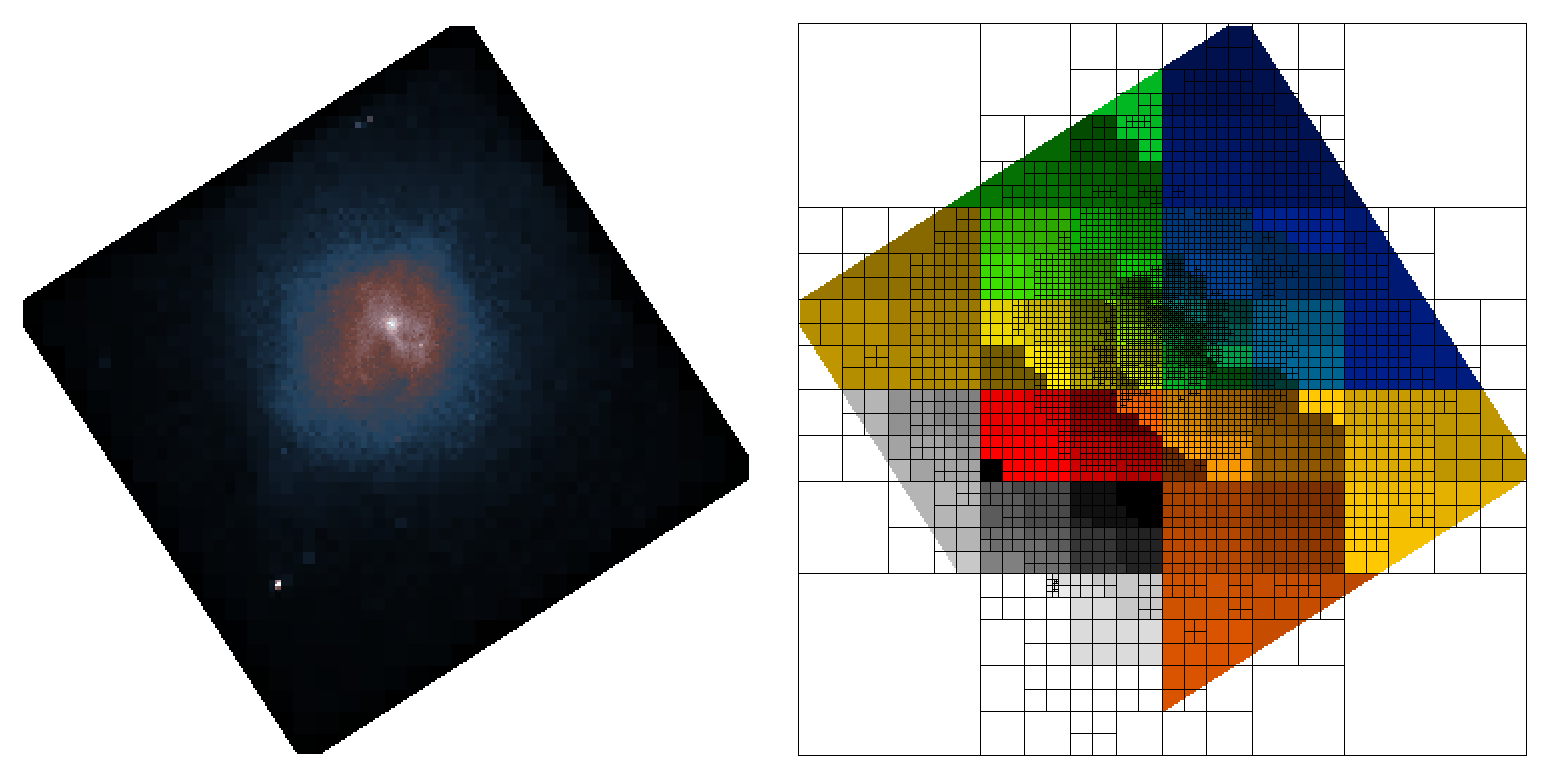

In [4]:
dmnautilus img.dss.fits nautilus.0.img 15.8 outmask=nautilus.0.map method=0 clob+
display_map nautilus.0.img nautilus.0.map nautilus.0.png

## Example `method=1:4` 

The `method` parameter controls the number of sub-images in the 2x2 grid which must be above the SNR limit.

- `method=1` requires any 1 of the 2x2 subimages be above the SNR limit.
- `method=2` requires 2 of the 2x2 submiages to be above the SNR limit.  The two must share a side (ie not diagonal)
- `method=3` requires 3 of the 2x2 subimages to be above the SNR limit.
- `method=4` requires all 4 of the 2x2 subimage to be above the SNR limit.

In general, the size of the groups will be smaller for lower method values. 



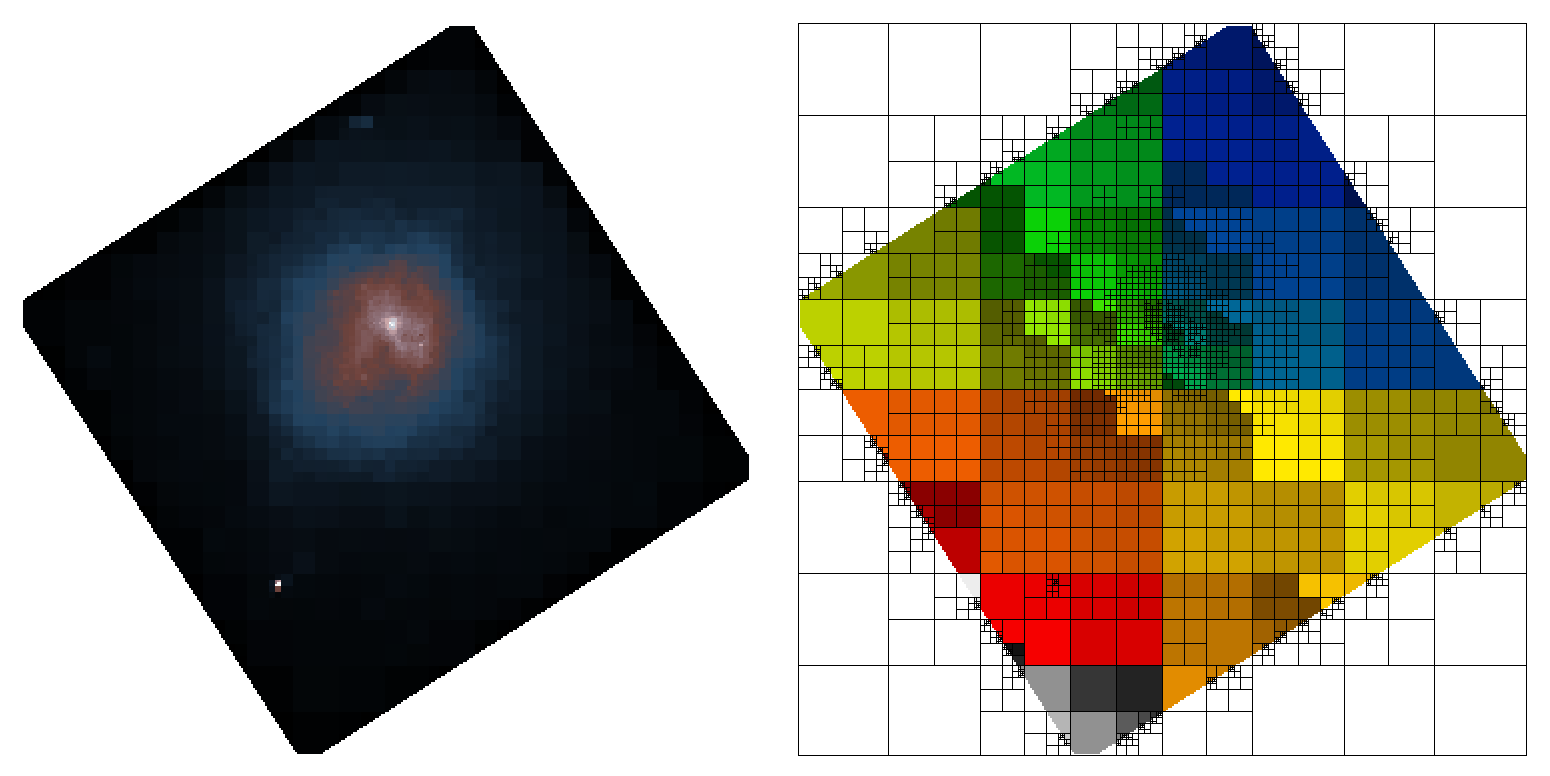

In [5]:
dmnautilus img.dss.fits nautilus.1.img 15.8 outmask=nautilus.1.map method=1 clob+
display_map nautilus.1.img nautilus.1.map nautilus.1.png

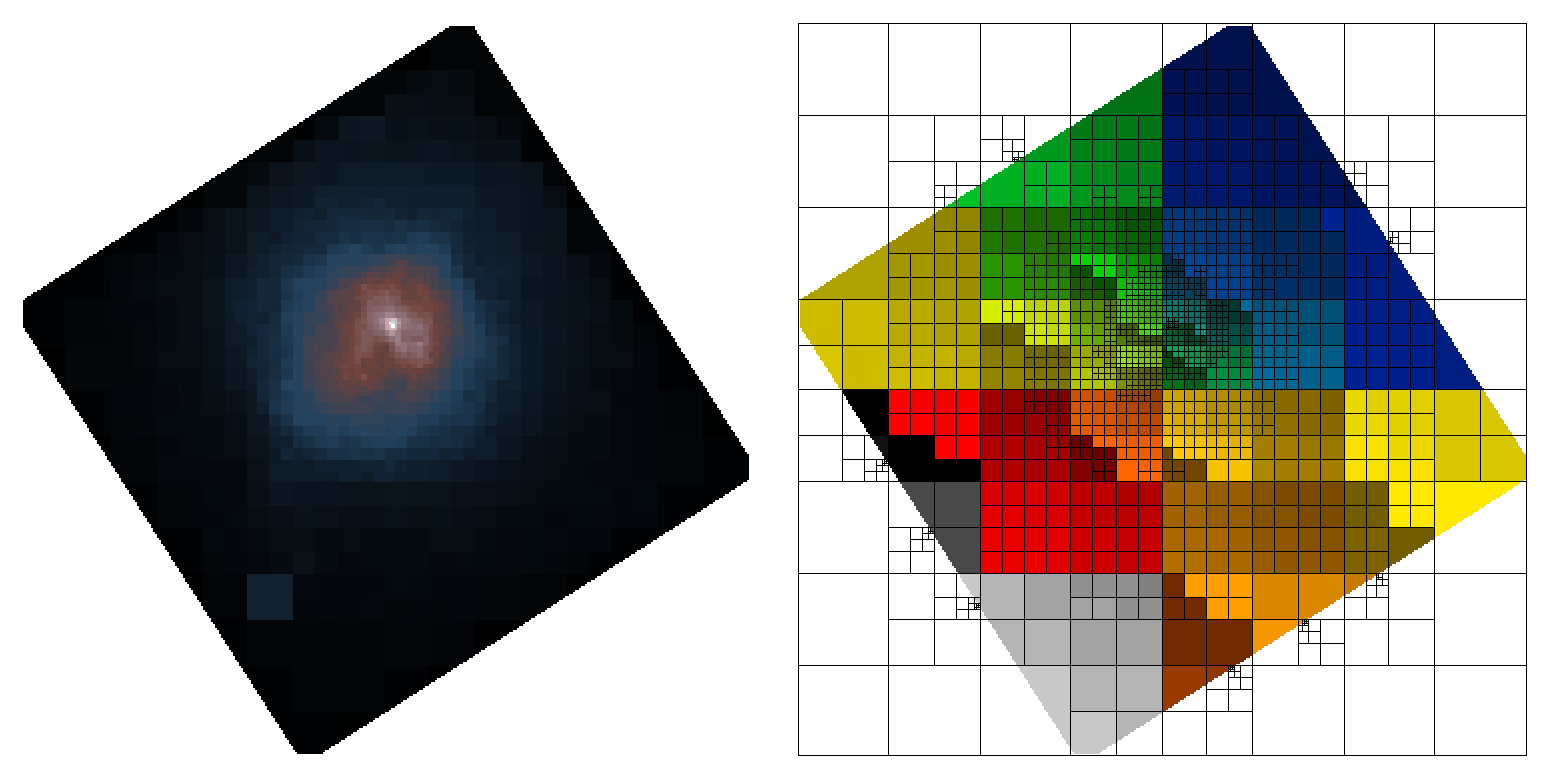

In [6]:
dmnautilus img.dss.fits nautilus.2.img 15.8 outmask=nautilus.2.map method=2 clob+
display_map nautilus.2.img nautilus.2.map nautilus.2.png

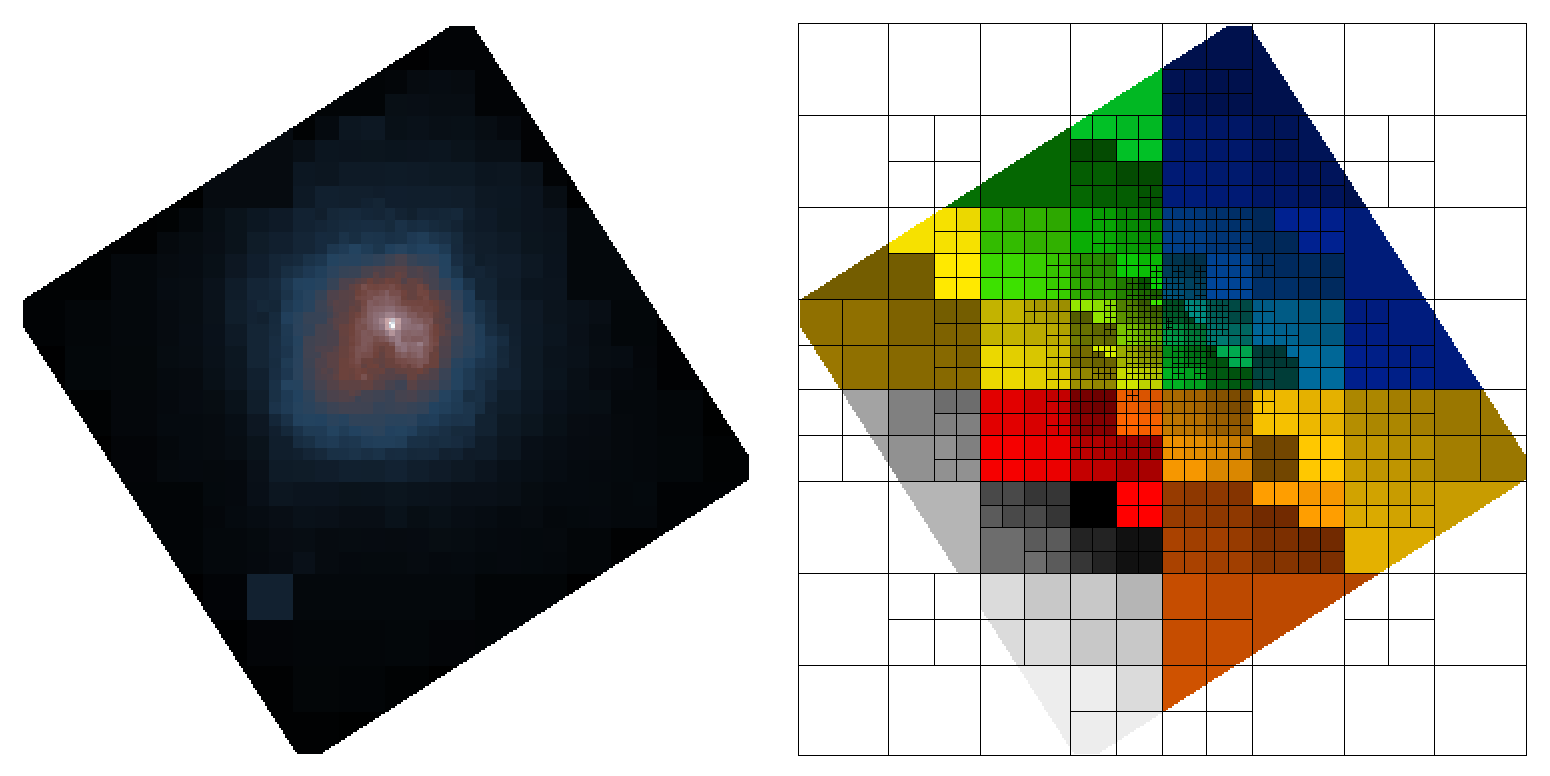

In [7]:
dmnautilus img.dss.fits nautilus.3.img 15.8 outmask=nautilus.3.map method=3 clob+
display_map nautilus.3.img nautilus.3.map nautilus.3.png

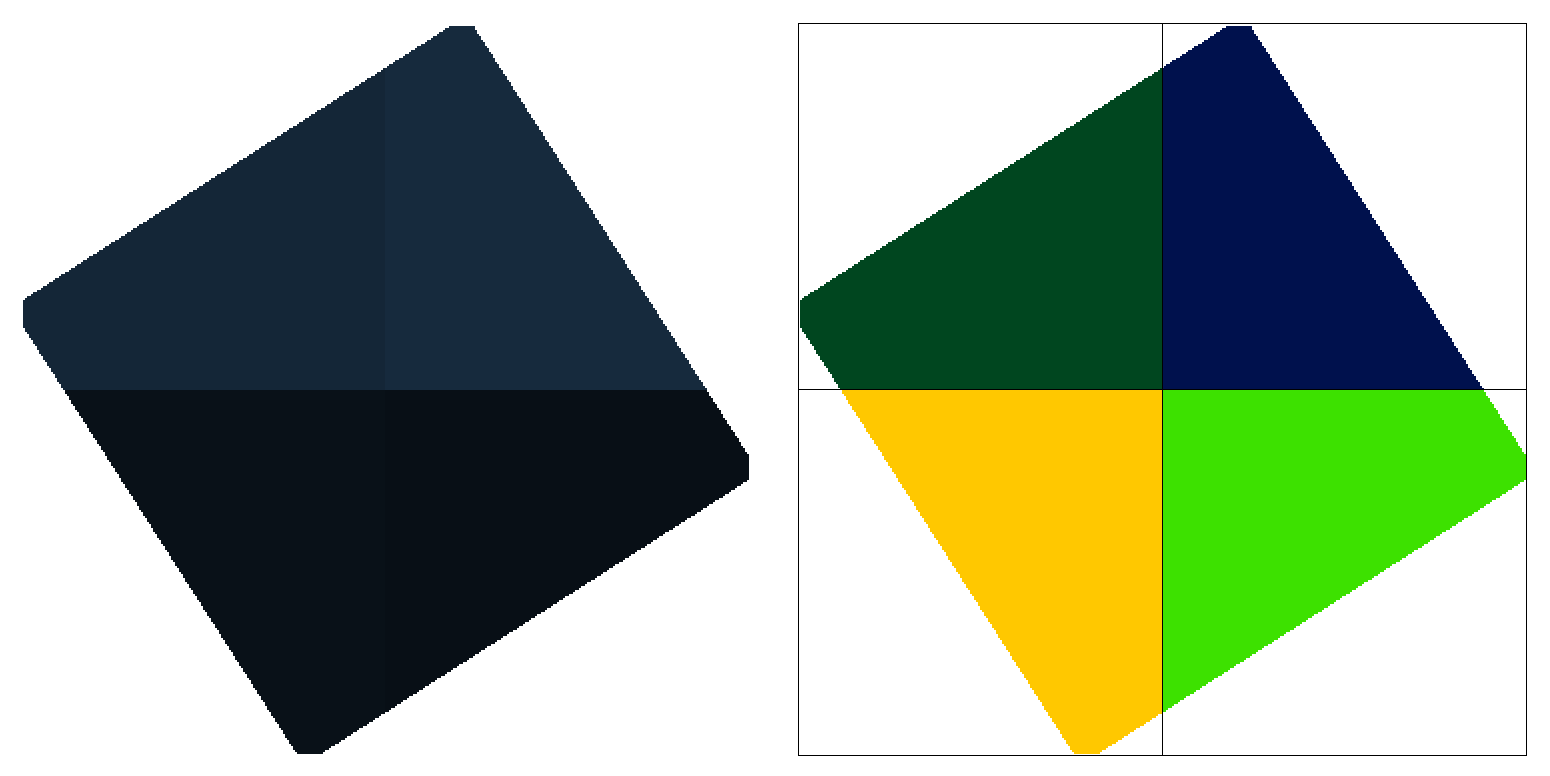

In [8]:
dmnautilus img.dss.fits nautilus.4.img 15.8 outmask=nautilus.4.map method=4 clob+
display_map nautilus.4.img nautilus.4.map nautilus.4.png

For `method=1|2|3` you can see the difference primarily along the edge of the field-of-view.  By allowing the 
SNR to be lower than the SNR, the edge can captured.

Unfortunately, with `method=4`, things become problematic.  The image is subdivided into 2x2, but then is unable to 
subdivide further because of the edge running diagonally through the sub-image.

If the dataset extended to (or past) the edge of the image then this less often a problem.  Similarly, if we rotate the image to align the FOV edge to the image edge then 


## Example, `method=4` with rotated input

To overcome the problems with `method=4`, we need to establish the edge of the field and it
also helps to rotate the image to make the chip edges parallel to the image axes. 

We start by rotating the image.  Luckily, we can rotate by the `ROLL_PNT` value (for a single
OBI image), about the center of the image (in image coordinates) using the [`dmregrid2`](http://cxc.cfa.harvard.edu/ciao/ahelp/dmregrid2.html) tool.

In [9]:
dmkeypar img.fits ROLL_PNT echo+

57.328032904442


In [10]:
dmlist img.fits blocks | grep EVENTS_IMAGE

Block    1: EVENTS_IMAGE                   Image      Int2(364x366)


In [11]:
echo "364/2" | bc 
echo "366/2" | bc

182
183


In [12]:
# Rotate by ROLL_PNT about center to align edge
dmregrid2 img.fits img.rot res=1 method=sum theta=57.328 rotx=182 roty=183 clob+

Next we need to compute the FOV boundary in the rotated image space.  We could probably compute it 
using `dmtcalc` but it's also easy to find the edge of the image using
`dmimghull`. 

In [13]:
# Find convex hull around non-zero pixels (ie rotated field-of-view)
dmimghull img.rot img.rot.hull clob+

In [14]:
# Now run dmnautilus as before
dmnautilus "img.rot[sky=region(img.rot.hull)][opt full]" \
  img.rot.abin outmask=img.rot.map snr=15.8 meth=4 clob+

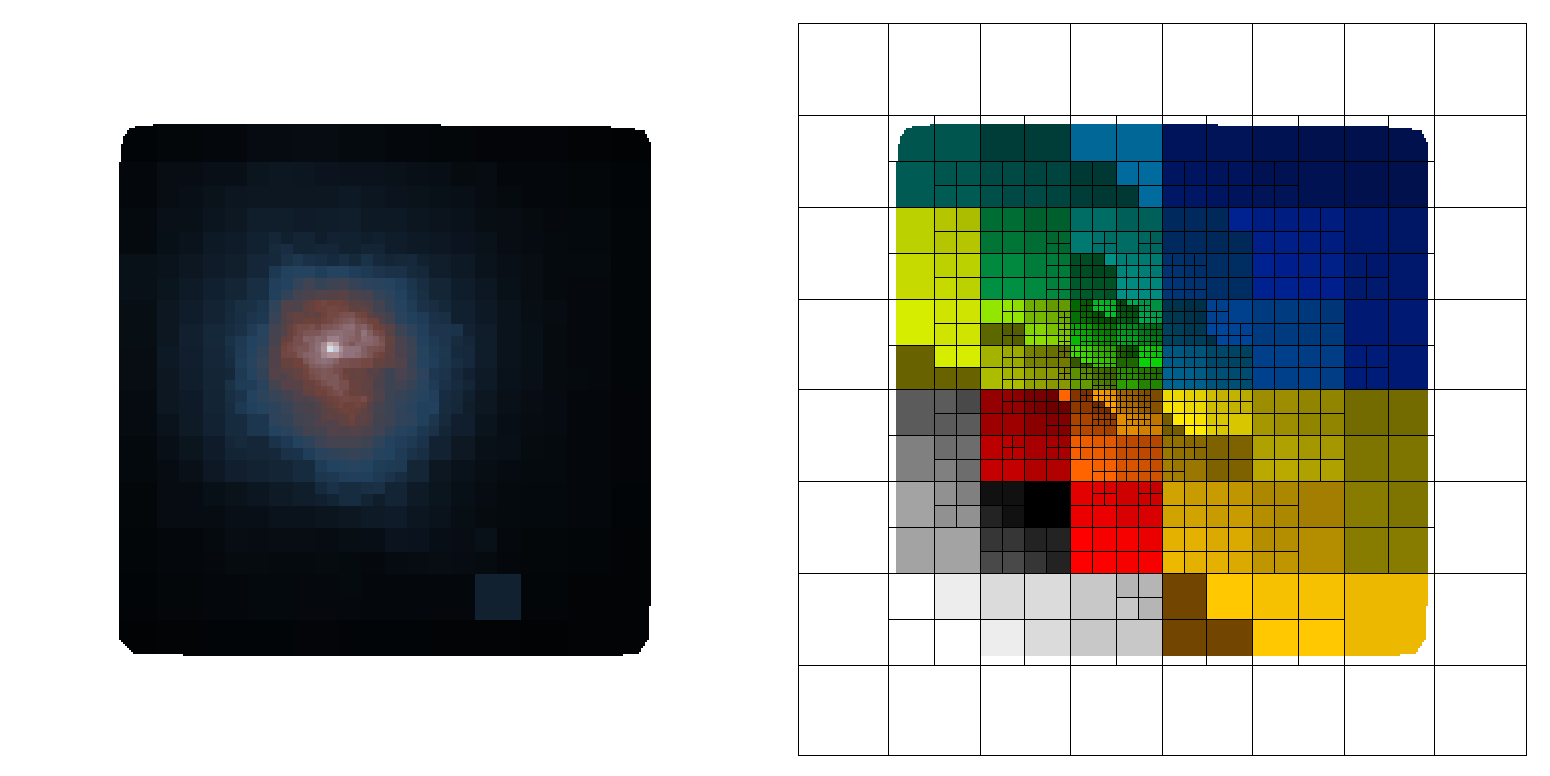

In [15]:
display_map img.rot.abin img.rot.map img.rot.png 

This looks much better.  With the edge of the images aligned with the FOV boundary, the algorithm can 
subdivide the image into 2x2 subgrids.

Now we just need to rotate things back.  We rotate the map back to normal 
sky coordinates, and then create the binned image using `dmmaskbin`

In [16]:
# It is important here that dmregrid2 uses resolution=0 which does not interpolate the map values.
dmregrid2 img.rot.map img.rot.rot.map res=0 method=sum \
  theta=-57.328 rotx=182 roty=183 clob+

dmmaskbin img.fits "img.rot.rot.map[opt type=i4]" img.rot.rot.img clob+

In [17]:
map2reg img.rot.rot.map img.rot.rot.reg 

map2reg
          infile = img.rot.rot.map
         outfile = img.rot.rot.reg
         verbose = 1
         clobber = no
            mode = ql

4.0
226.0
449.0
665.0
5.0
666.0
227.0
450.0
667.0
6.0
230.0
451.0
668.0
232.0
7.0
452.0
669.0
233.0
10.0
453.0
670.0
234.0
11.0
454.0
235.0
671.0
12.0
455.0
236.0
672.0
13.0
456.0
237.0
673.0
14.0
457.0
674.0
238.0
15.0
458.0
675.0
239.0
16.0
459.0
240.0
676.0
17.0
460.0
677.0
461.0
241.0
18.0
678.0
462.0
19.0
242.0
679.0
463.0
243.0
20.0
680.0
464.0
244.0
22.0
681.0
465.0
245.0
23.0
682.0
246.0
466.0
24.0
467.0
25.0
683.0
247.0
468.0
26.0
684.0
248.0
469.0
27.0
685.0
249.0
470.0
28.0
686.0
250.0
471.0
30.0
687.0
251.0
472.0
31.0
688.0
252.0
689.0
32.0
473.0
253.0
690.0
33.0
474.0
254.0
691.0
34.0
475.0
255.0
692.0
35.0
476.0
256.0
36.0
693.0
477.0
257.0
37.0
694.0
478.0
258.0
38.0
695.0
479.0
259.0
39.0
696.0
480.0
260.0
40.0
697.0
481.0
261.0
41.0
699.0
482.0
262.0
42.0
700.0
483.0
263.0
43.0
701.0
484.0
264.0
44.0
702.0
485.0
265.0
45.0
703.

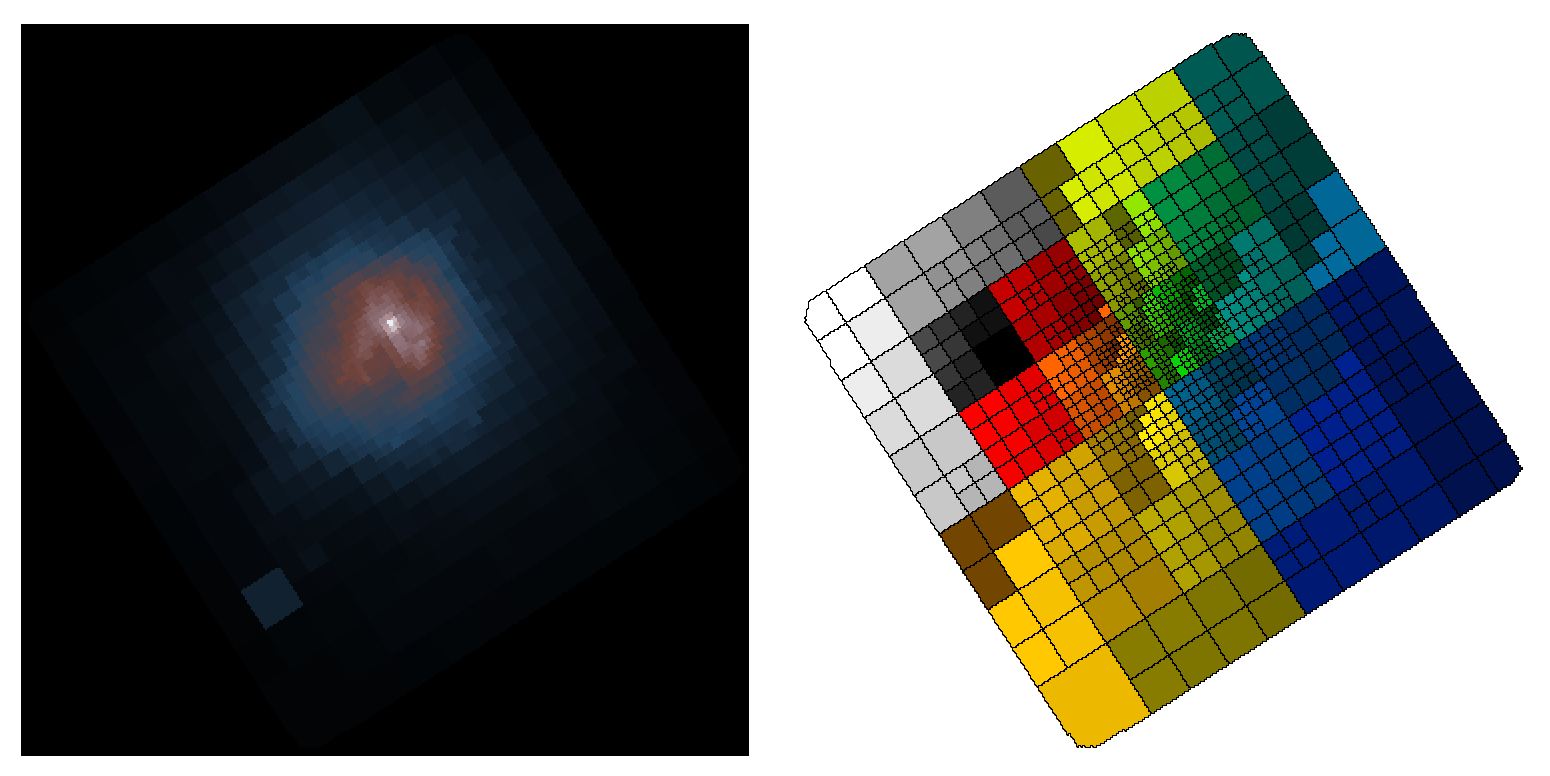

In [18]:
display_map img.rot.rot.img img.rot.rot.map img.rot.rot.png img.rot.rot.reg

The result is a rotated map and rotated groups.
